In [ ]:
pip install fastNLP

In [ ]:
pip install transformers

# Bert_CRF

In [ ]:


from torch import nn
from fastNLP.modules import ConditionalRandomField, allowed_transitions
import torch.nn.functional as F

class BertCRF(nn.Module):
    def __init__(self, embed, tag_vocab, encoding_type='bio'):
        super().__init__()
        self.embed = embed
        self.fc = nn.Linear(self.embed.embed_size, len(tag_vocab))
        trans = allowed_transitions(tag_vocab, encoding_type=encoding_type, include_start_end=True)
        self.crf = ConditionalRandomField(len(tag_vocab), include_start_end_trans=True, allowed_transitions=trans)

    def _forward(self, words, target):
        mask = words.ne(0)
        words = self.embed(words)
        words = self.fc(words)
        logits = F.log_softmax(words, dim=-1)
        if target is not None:
            loss = self.crf(logits, target, mask)
            return {'loss': loss}
        else:
            paths, _ = self.crf.viterbi_decode(logits, mask)
            return {'pred': paths}

    def forward(self, words, target):
        return self._forward(words, target)

    def predict(self, words):
        return self._forward(words, None)

In [ ]:


"""
使用Bert进行英文命名实体识别

"""

import sys

sys.path.append('../../../')


from fastNLP.embeddings import BertEmbedding
from fastNLP import Trainer, Const
from fastNLP import BucketSampler, SpanFPreRecMetric, GradientClipCallback
from fastNLP.core.callback import WarmupCallback
from fastNLP.core.optimizer import AdamW
from fastNLP.io import Conll2003NERPipe

from fastNLP import cache_results, EvaluateCallback

encoding_type = 'bioes'

@cache_results('caches/conll2003.pkl', _refresh=False)
def load_data():
    # 替换路径
    paths = 'data/conll2003'
    data = Conll2003NERPipe(encoding_type=encoding_type).process_from_file(paths)
    return data
data = load_data()
print(data)

embed = BertEmbedding(data.get_vocab(Const.INPUT), model_dir_or_name='en-base-cased',
                        pool_method='max', requires_grad=True, layers='11', include_cls_sep=False, dropout=0.5,
                      word_dropout=0.01)

callbacks = [
                GradientClipCallback(clip_type='norm', clip_value=1),
                WarmupCallback(warmup=0.1, schedule='linear'),
                EvaluateCallback(data.get_dataset('test'))
            ]

model = BertCRF(embed, tag_vocab=data.get_vocab('target'), encoding_type=encoding_type)
optimizer = AdamW(model.parameters(), lr=2e-5)

trainer = Trainer(train_data=data.datasets['train'], model=model, optimizer=optimizer, sampler=BucketSampler(),
                  device=0, dev_data=data.datasets['dev'], batch_size=6,
                  metrics=SpanFPreRecMetric(tag_vocab=data.vocabs[Const.TARGET], encoding_type=encoding_type),
                  loss=None, callbacks=callbacks, num_workers=2, n_epochs=1,
                  check_code_level=0, update_every=3, test_use_tqdm=False)
trainer.train()


Read cache from caches/conll2003.pkl.
In total 3 datasets:
	dev has 3250 instances.
	test has 3453 instances.
	train has 14041 instances.
In total 2 vocabs:
	words has 30291 entries.
	target has 17 entries.

loading vocabulary file /root/.fastNLP/embedding/bert-base-cased/vocab.txt
Load pre-trained BERT parameters from file /root/.fastNLP/embedding/bert-base-cased/pytorch_model.bin.
Bert Model will return 1 layers (layer-0 is embedding result): [11]
input fields after batch(if batch size is 2):
	target: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2, 9]) 
	words: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2, 9]) 
	seq_len: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2]) 
target fields after batch(if batch size is 2):
	target: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2, 9]) 
	seq_len: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2]) 

training epochs started 2022-06-27-09-46-01-715291


  0%|          | 0/2341 [00:00<?, ?it/s, loss:{0:<6.5f}]

Evaluate data in 22.37 seconds!
Evaluate data in 18.18 seconds!
EvaluateCallback evaluation on data-test:
SpanFPreRecMetric: f=0.895997, pre=0.894338, rec=0.897663
Evaluation on dev at Epoch 1/1. Step:2341/2341: 
SpanFPreRecMetric: f=0.926516, pre=0.928946, rec=0.9241

Reloaded the best model.

In Epoch:1/Step:2341, got best dev performance:
SpanFPreRecMetric: f=0.926516, pre=0.928946, rec=0.9241


{'best_epoch': 1,
 'best_eval': {'SpanFPreRecMetric': {'f': 0.926516,
   'pre': 0.928946,
   'rec': 0.9241}},
 'best_step': 2341,
 'seconds': 273.67}

In [11]:
data = load_data()

Read cache from caches/conll2003.pkl.


In [13]:
from fastNLP import Tester
tester = Tester(data=data.datasets['test'], model=model, metrics=SpanFPreRecMetric(tag_vocab=data.vocabs[Const.TARGET]))
tester.test()


  0%|          | 0/216 [00:00<?, ?it/s]

Evaluate data in 14.02 seconds!
[tester] 
SpanFPreRecMetric: f=0.895997, pre=0.894338, rec=0.897663


{'SpanFPreRecMetric': {'f': 0.895997, 'pre': 0.894338, 'rec': 0.897663}}

# CNNBiLSTMCRF

In [14]:

from torch import nn
from fastNLP import seq_len_to_mask
from fastNLP.modules import LSTM
from fastNLP.modules import ConditionalRandomField, allowed_transitions
import torch.nn.functional as F
from fastNLP import Const

class CNNBiLSTMCRF(nn.Module):
    def __init__(self, embed, hidden_size, num_layers, tag_vocab, dropout=0.5, encoding_type='bioes'):
        super().__init__()
        self.embedding = embed
        self.lstm = LSTM(input_size=self.embedding.embedding_dim,
                             hidden_size=hidden_size//2, num_layers=num_layers,
                             bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size, len(tag_vocab))

        transitions = allowed_transitions(tag_vocab.idx2word, encoding_type=encoding_type, include_start_end=True)
        self.crf = ConditionalRandomField(len(tag_vocab), include_start_end_trans=True, allowed_transitions=transitions)

        self.dropout = nn.Dropout(dropout, inplace=True)

        for name, param in self.named_parameters():
            if 'fc' in name:
                if param.data.dim()>1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.constant_(param, 0)
            if 'crf' in name:
                nn.init.zeros_(param)

    def _forward(self, words, seq_len, target=None):
        words = self.embedding(words)
        outputs, _ = self.lstm(words, seq_len)
        self.dropout(outputs)

        logits = F.log_softmax(self.fc(outputs), dim=-1)

        if target is not None:
            loss = self.crf(logits, target, seq_len_to_mask(seq_len, max_len=logits.size(1))).mean()
            return {Const.LOSS: loss}
        else:
            pred, _ = self.crf.viterbi_decode(logits, seq_len_to_mask(seq_len, max_len=logits.size(1)))
            return {Const.OUTPUT: pred}

    def forward(self, words, seq_len, target):
        return self._forward(words, seq_len, target)

    def predict(self, words, seq_len):
        return self._forward(words, seq_len, None)

In [17]:
import sys
sys.path.append('../../..')

from fastNLP.embeddings import CNNCharEmbedding, StaticEmbedding, StackEmbedding

# from reproduction.sequence_labelling.ner.model.lstm_cnn_crf import CNNBiLSTMCRF
from fastNLP import Trainer
from fastNLP import SpanFPreRecMetric
from fastNLP import BucketSampler
from fastNLP import Const
from torch.optim import SGD
from fastNLP import GradientClipCallback
from fastNLP.core.callback import EvaluateCallback, LRScheduler
from torch.optim.lr_scheduler import LambdaLR
from fastNLP import cache_results

from fastNLP.io.pipe.conll import Conll2003NERPipe
encoding_type = 'bioes'
@cache_results('caches/conll2003_new.pkl', _refresh=True)
def load_data():
    # 替换路径
    paths = {'test':"data/conll2003/test.txt",
             'train':"data/conll2003/train.txt",
             'dev':"data/conll2003/dev.txt"}
    data = Conll2003NERPipe(encoding_type=encoding_type).process_from_file(paths)
    return data
data = load_data()
print(data)

char_embed = CNNCharEmbedding(vocab=data.get_vocab('words'), embed_size=30, char_emb_size=30, filter_nums=[30],
                              kernel_sizes=[3], word_dropout=0, dropout=0.5)
word_embed = StaticEmbedding(vocab=data.get_vocab('words'),
                             model_dir_or_name='en-glove-6b-100d',
                             requires_grad=True, lower=True, word_dropout=0.01, dropout=0.5)
word_embed.embedding.weight.data = word_embed.embedding.weight.data/word_embed.embedding.weight.data.std()
embed = StackEmbedding([word_embed, char_embed])

model = CNNBiLSTMCRF(embed, hidden_size=200, num_layers=1, tag_vocab=data.vocabs[Const.TARGET],
                     encoding_type=encoding_type)

callbacks = [
            GradientClipCallback(clip_type='value', clip_value=5),
            EvaluateCallback(data=data.get_dataset('test'))  # 额外对test上的数据进行性能评测
            ]

optimizer = SGD(model.parameters(), lr=0.008, momentum=0.9)
scheduler = LRScheduler(LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (1 + 0.05 * epoch)))
callbacks.append(scheduler)

trainer = Trainer(train_data=data.get_dataset('train'), model=model, optimizer=optimizer, sampler=BucketSampler(),
                  device=0, dev_data=data.get_dataset('dev'), batch_size=20,
                  metrics=SpanFPreRecMetric(tag_vocab=data.vocabs[Const.TARGET], encoding_type=encoding_type),
                  callbacks=callbacks, num_workers=2, n_epochs=100, dev_batch_size=512)
trainer.train()

Save cache to caches/conll2003_new.pkl.
In total 3 datasets:
	test has 3453 instances.
	train has 14041 instances.
	dev has 3250 instances.
In total 2 vocabs:
	words has 30291 entries.
	target has 17 entries.

Start constructing character vocabulary.
In total, there are 82 distinct characters.


  0%|          | 0.00/123M [00:00<?, ?B/s]

http://download.fastnlp.top/embedding/glove.6B.100d.zip not found in cache, downloading to /tmp/tmp7djbzlja


100%|██████████| 123M/123M [02:30<00:00, 816kB/s] 


Finish download from http://download.fastnlp.top/embedding/glove.6B.100d.zip
Copy file to /root/.fastNLP/embedding/glove.6B.100d
All word in the vocab have been lowered. There are 30291 words, 26871 unique lowered words.
Found 22947 out of 26871 words in the pre-training embedding.
input fields after batch(if batch size is 2):
	target: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2, 9]) 
	words: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2, 9]) 
	seq_len: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2]) 
target fields after batch(if batch size is 2):
	target: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2, 9]) 
	seq_len: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2]) 

training epochs started 2022-06-27-10-17-08-920657


  0%|          | 0/70300 [00:00<?, ?it/s, loss:{0:<6.5f}]

  0%|          | 0/7 [00:00<?, ?it/s]

Evaluate data in 0.87 seconds!


  0%|          | 0/7 [00:00<?, ?it/s]

Evaluate data in 0.68 seconds!
EvaluateCallback evaluation on data-test:
SpanFPreRecMetric: f=0.790668, pre=0.801528, rec=0.780099
Evaluation on dev at Epoch 1/100. Step:703/70300: 
SpanFPreRecMetric: f=0.825625, pre=0.8406, rec=0.811175



/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/7 [00:00<?, ?it/s]

Evaluate data in 0.87 seconds!


  0%|          | 0/7 [00:00<?, ?it/s]

Evaluate data in 0.66 seconds!
EvaluateCallback evaluation on data-test:
SpanFPreRecMetric: f=0.841807, pre=0.842255, rec=0.84136
Evaluation on dev at Epoch 2/100. Step:1406/70300: 
SpanFPreRecMetric: f=0.875506, pre=0.877579, rec=0.873443



  0%|          | 0/7 [00:00<?, ?it/s]

Evaluate data in 0.86 seconds!


  0%|          | 0/7 [00:00<?, ?it/s]

Evaluate data in 0.88 seconds!
EvaluateCallback evaluation on data-test:
SpanFPreRecMetric: f=0.856639, pre=0.853179, rec=0.860127
Evaluation on dev at Epoch 3/100. Step:2109/70300: 
SpanFPreRecMetric: f=0.891262, pre=0.890738, rec=0.891787

Reloaded the best model.

In Epoch:3/Step:2109, got best dev performance:
SpanFPreRecMetric: f=0.891262, pre=0.890738, rec=0.891787


{'best_epoch': 3,
 'best_eval': {'SpanFPreRecMetric': {'f': 0.891262,
   'pre': 0.890738,
   'rec': 0.891787}},
 'best_step': 2109,
 'seconds': 93.12}

In [18]:
from fastNLP import Tester
tester = Tester(data=data.datasets['test'], model=model, metrics=SpanFPreRecMetric(tag_vocab=data.vocabs[Const.TARGET]))
tester.test()

  0%|          | 0/216 [00:00<?, ?it/s]

Evaluate data in 4.36 seconds!
[tester] 
SpanFPreRecMetric: f=0.856463, pre=0.853003, rec=0.85995


{'SpanFPreRecMetric': {'f': 0.856463, 'pre': 0.853003, 'rec': 0.85995}}

#文件目录形式

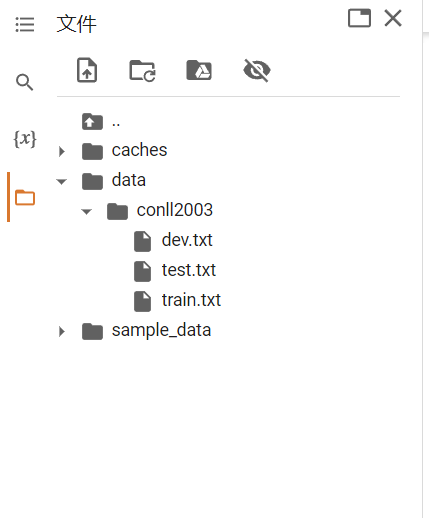